In [16]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor,RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_curve, auc,precision_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve
import xgboost as xgb

from sklearn.metrics import accuracy_score,recall_score,f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.neural_network import MLPRegressor

In [2]:
conda install -c conda-forge xgboost

Retrieving notices: ...working... done
Solving environment: ...working... done

## Package Plan ##

  environment location: D:\Application\Anaconda3

  added / updated specs:
    - xgboost


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _py-xgboost-mutex-2.0      |            cpu_0          11 KB  conda-forge
    ca-certificates-2024.2.2   |       h56e8100_0         152 KB  conda-forge
    certifi-2024.2.2           |     pyhd8ed1ab_0         157 KB  conda-forge
    libxgboost-1.7.3           |       hd77b12b_0         1.5 MB
    py-xgboost-1.7.3           |  py310haa95532_0         200 KB
    xgboost-1.7.3              |  py310haa95532_0          12 KB
    ------------------------------------------------------------
                                           Total:         2.0 MB

The following NEW packages will be INSTALLED:

  _py-xgboost-mutex  conda-forge/win-64::_py-xgboost-mutex



==> WARNING: A newer version of conda exists. <==
  current version: 23.1.0
  latest version: 24.1.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.1.0




In [3]:
# 分组数据以找到每个游戏的开始和结束
grouped = data.groupby(['match_id', 'set_no', 'game_no'])

# 初始化计数器
first_server_game_wins = 0
total_games = 0

for name, group in grouped:
    # 每个游戏的第一条记录
    first_point = group.iloc[0]
    # 每个游戏的最后一条记录
    last_point = group.iloc[-1]
    
    # 确定发球方
    server = first_point['server']
    # 确定获胜方
    game_victor = last_point['game_victor']
    
    # 计算先发球者获胜的游戏数
    if server == game_victor:
        first_server_game_wins += 1
    total_games += 1

# 计算先发球者获胜的比例
first_server_game_win_ratio = first_server_game_wins / total_games

print(f"Total games: {total_games}")
print(f"First server game wins: {first_server_game_wins}")
print(f"First server game win ratio: {first_server_game_win_ratio:.4f}")

Total games: 1188
First server game wins: 999
First server game win ratio: 0.8409


In [2]:
# 假设的先发球者获胜比例
server_win_ratio = 0.8409

# 加载数据
data = pd.read_csv('Wimbledon_featured_matches.csv')

# 确保数据按照比赛和时间顺序排序
data.sort_values(by=['match_id', 'set_no', 'game_no', 'point_no'], inplace=True)

# 初始化状态转移计数字典
transition_counts = {}

# 遍历数据集，记录状态转移
for i in range(1, len(data)):
    prev_row = data.iloc[i-1]
    current_row = data.iloc[i]
    
    # 获取前一个点和当前点的盘数胜利情况
    prev_state = (prev_row['p1_sets'], prev_row['p2_sets'])
    current_state = (current_row['p1_sets'], current_row['p2_sets'])
    
    # 如果盘数胜利情况发生了变化，则记录状态转移
    if prev_state != current_state and all(x < 3 for x in prev_state):
        if prev_state not in transition_counts:
            transition_counts[prev_state] = {}
        if current_state not in transition_counts[prev_state]:
            transition_counts[prev_state][current_state] = 0
        transition_counts[prev_state][current_state] += 1

# 调整转移概率计算，考虑先发球者获胜的比例
transition_probabilities = {}
for start_state, transitions in transition_counts.items():
    total_transitions = sum(transitions.values())
    adjusted_probabilities = {}
    for end_state, count in transitions.items():
        # 调整转移概率
        if start_state[0] < end_state[0]:  # 玩家1赢得新的盘
            adjusted_probabilities[end_state] = server_win_ratio * (count / total_transitions)
        elif start_state[1] < end_state[1]:  # 玩家2赢得新的盘
            adjusted_probabilities[end_state] = (1 - server_win_ratio) * (count / total_transitions)
        else:  # 盘数没有变化，保持原始计算方法
            adjusted_probabilities[end_state] = count / total_transitions
    transition_probabilities[start_state] = adjusted_probabilities

# 输出调整后的转移概率矩阵
for start_state, transitions in transition_probabilities.items():
    print(f"From {start_state}:")
    for end_state, probability in transitions.items():
        print(f"  To {end_state}: {probability:.4f}")

From (0, 0):
  To (1, 0): 0.4069
  To (0, 1): 0.0821
From (1, 0):
  To (1, 1): 0.0742
  To (2, 0): 0.3924
  To (0, 0): 0.0667
From (1, 1):
  To (2, 1): 0.6167
  To (1, 2): 0.0424
From (2, 1):
  To (0, 0): 0.6154
  To (2, 2): 0.0612
From (0, 1):
  To (0, 2): 0.0796
  To (1, 1): 0.4204
From (0, 2):
  To (0, 0): 0.8750
  To (1, 2): 0.1051
From (2, 2):
  To (0, 0): 1.0000
From (2, 0):
  To (2, 1): 0.0455
  To (0, 0): 0.7143
From (1, 2):
  To (0, 0): 0.6000
  To (2, 2): 0.3364


In [9]:
p1 = pd.read_csv('.\p1_score.csv')
p1

,Unnamed: 0,p1_ace,p1_winner,p1_unf_err,p1_break_pt_won,p1_net_pt_won,server,match_id,p1_score,set_no,game_no
0,0,0,0,1,0,0,1,2023-wimbledon-1301,0.000,1,1
1,1,0,0,0,0,0,1,2023-wimbledon-1301,-0.213,1,1
2,2,0,0,1,0,0,1,2023-wimbledon-1301,0.000,1,1
3,3,0,1,0,0,0,1,2023-wimbledon-1301,-0.213,1,1
4,4,1,1,0,0,0,1,2023-wimbledon-1301,0.405,1,1
...,...,...,...,...,...,...,...,...,...,...,...
7279,7279,0,1,0,0,0,1,2023-wimbledon-1701,-0.213,5,10
7280,7280,0,1,0,0,1,1,2023-wimbledon-1701,0.405,5,10
7281,7281,0,0,0,0,0,1,2023-wimbledon-1701,0.405,5,10
7282,7282,0,0,0,0,0,1,2023-wimbledon-1701,0.000,5,10


In [10]:
p2 = pd.read_csv('.\p2_score.csv')
p2

,Unnamed: 0,p2_ace,p2_winner,p2_unf_err,p2_break_pt_won,p2_net_pt_won,server,match_id,p2_score,set_no,game_no
0,0,0,0,0,0,0,0,2023-wimbledon-1301,0.000,1,1
1,1,0,0,0,0,0,0,2023-wimbledon-1301,0.000,1,1
2,2,0,0,0,0,0,0,2023-wimbledon-1301,0.000,1,1
3,3,0,0,0,0,0,0,2023-wimbledon-1301,0.000,1,1
4,4,0,0,0,0,0,0,2023-wimbledon-1301,0.000,1,1
...,...,...,...,...,...,...,...,...,...,...,...
7279,7279,0,0,0,0,0,0,2023-wimbledon-1701,0.000,5,10
7280,7280,0,0,0,0,0,0,2023-wimbledon-1701,0.000,5,10
7281,7281,0,1,0,0,0,0,2023-wimbledon-1701,0.405,5,10
7282,7282,0,0,0,0,0,0,2023-wimbledon-1701,0.000,5,10


In [11]:
p1 = pd.concat([p1, p2['p2_score']], axis=1)
p1

,Unnamed: 0,p1_ace,p1_winner,p1_unf_err,p1_break_pt_won,p1_net_pt_won,server,match_id,p1_score,set_no,game_no,p2_score
0,0,0,0,1,0,0,1,2023-wimbledon-1301,0.000,1,1,0.000
1,1,0,0,0,0,0,1,2023-wimbledon-1301,-0.213,1,1,0.000
2,2,0,0,1,0,0,1,2023-wimbledon-1301,0.000,1,1,0.000
3,3,0,1,0,0,0,1,2023-wimbledon-1301,-0.213,1,1,0.000
4,4,1,1,0,0,0,1,2023-wimbledon-1301,0.405,1,1,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...
7279,7279,0,1,0,0,0,1,2023-wimbledon-1701,-0.213,5,10,0.000
7280,7280,0,1,0,0,1,1,2023-wimbledon-1701,0.405,5,10,0.000
7281,7281,0,0,0,0,0,1,2023-wimbledon-1701,0.405,5,10,0.405
7282,7282,0,0,0,0,0,1,2023-wimbledon-1701,0.000,5,10,0.000


In [12]:
p1['delta'] = p1['p1_score'] - p1['p2_score']
p1

,Unnamed: 0,p1_ace,p1_winner,p1_unf_err,p1_break_pt_won,p1_net_pt_won,server,match_id,p1_score,set_no,game_no,p2_score,delta
0,0,0,0,1,0,0,1,2023-wimbledon-1301,0.000,1,1,0.000,0.000
1,1,0,0,0,0,0,1,2023-wimbledon-1301,-0.213,1,1,0.000,-0.213
2,2,0,0,1,0,0,1,2023-wimbledon-1301,0.000,1,1,0.000,0.000
3,3,0,1,0,0,0,1,2023-wimbledon-1301,-0.213,1,1,0.000,-0.213
4,4,1,1,0,0,0,1,2023-wimbledon-1301,0.405,1,1,0.000,0.405
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7279,7279,0,1,0,0,0,1,2023-wimbledon-1701,-0.213,5,10,0.000,-0.213
7280,7280,0,1,0,0,1,1,2023-wimbledon-1701,0.405,5,10,0.000,0.405
7281,7281,0,0,0,0,0,1,2023-wimbledon-1701,0.405,5,10,0.405,0.000
7282,7282,0,0,0,0,0,1,2023-wimbledon-1701,0.000,5,10,0.000,0.000


In [6]:
grouped_data1 = p1.groupby(['match_id'])['delta'].sum().values
points_won_lists1 = np.array(grouped_data1).tolist()
points_won_lists1

[0.38699999999999934,
 -1.209,
 -9.895,
 -3.4110000000000005,
 -2.585000000000001,
 11.430000000000001,
 10.497000000000002,
 2.519,
 -0.05500000000000038,
 2.72,
 -11.057,
 9.314,
 1.9490000000000003,
 8.707,
 -4.347,
 -11.479000000000001,
 1.8199999999999998,
 -0.7289999999999996,
 3.101,
 -2.107999999999999,
 5.391,
 2.3689999999999998,
 -0.6500000000000006,
 4.557,
 5.473,
 0.7179999999999994,
 6.573,
 -4.414000000000001,
 1.174,
 1.5000000000000002,
 13.139000000000001]

In [14]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual))


xgboost回归:
训练集平均绝对百分比误差:0.000
平均绝对误差: 0.18960686090747347
r2_score 0.0408113538744026


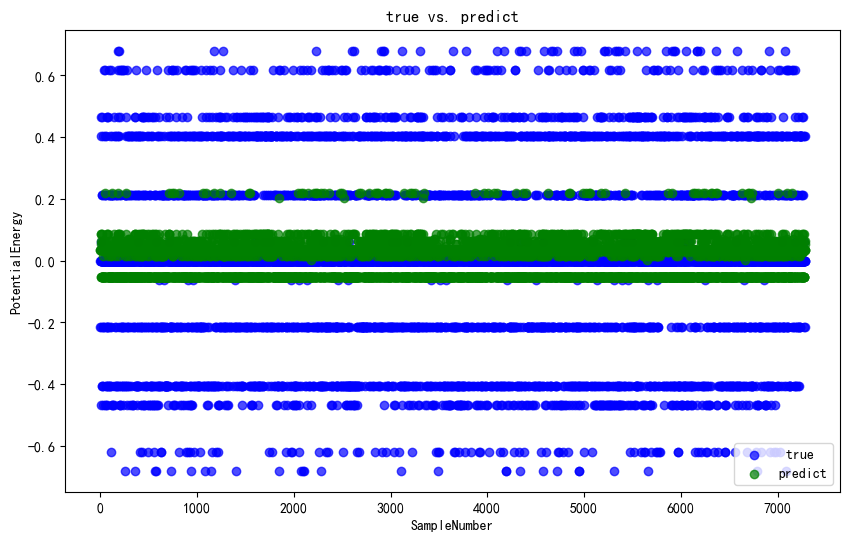

In [34]:
X = p1[['p1_ace', 'p1_winner', 'p1_unf_err', 'p1_break_pt_won', 'p1_net_pt_won', 'server']]
Y = p1['delta']

tr_x,te_x,tr_y,te_y=train_test_split(X ,Y,test_size=0.3,random_state=5)

print("\nxgboost回归:")
# 构建xgboost回归模型
xgb_model = xgb.XGBRegressor(n_estimators=31,max_depth=6)
xgb_model.fit(X,Y)
y_pred = xgb_model.predict(X)
print("训练集平均绝对百分比误差:{:.3f}".format(mape(xgb_model.predict(X),y_pred)))
print("平均绝对误差:",mean_absolute_error(Y, y_pred))
print("r2_score",r2_score(Y,y_pred))

plt.figure(figsize=(10, 6))

# 训练集
tr_y_pred = xgb_model.predict(tr_x)
plt.scatter(list(range(X.shape[0])), Y, color='blue', label=' true', alpha=0.7)
plt.scatter(list(range(X.shape[0])), y_pred, color='green', label='predict', alpha=0.7)

# 为图添加标题和图例
plt.title('true vs. predict')
plt.xlabel('SampleNumber')
plt.ylabel('PotentialEnergy')
plt.legend()
# 显示图形
plt.show()


随机森林回归:
训练集平均绝对百分比误差:4.522
测试集平均绝对百分比误差:4.521
平均绝对误差: 0.19111459272357142
r2_score 0.043290746859921625


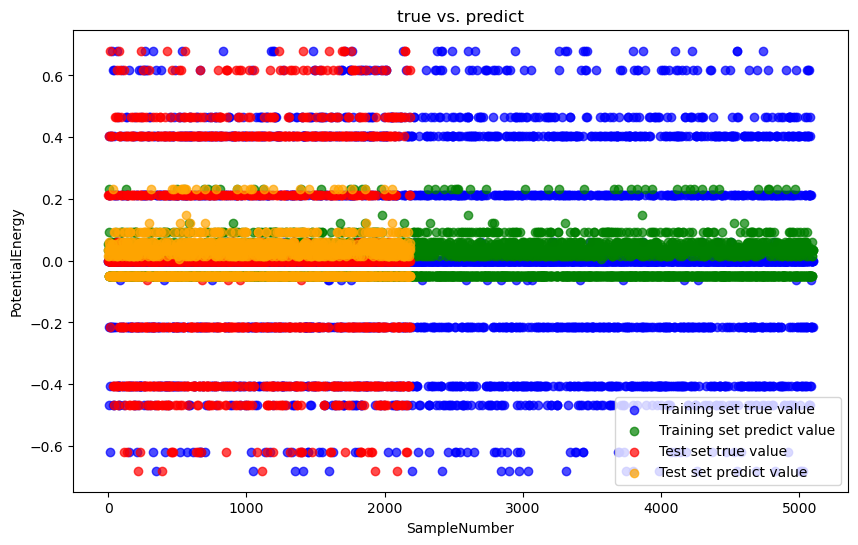

In [18]:
print("\n随机森林回归:")
rf=RandomForestRegressor()
rf.fit(tr_x,tr_y)

y_pred = rf.predict(te_x)

print("训练集平均绝对百分比误差:{:.3f}".format(mape(rf.predict(tr_x),tr_y)))
print("测试集平均绝对百分比误差:{:.3f}".format(mape(rf.predict(te_x),te_y)))
print("平均绝对误差:",mean_absolute_error(te_y, y_pred))
print("r2_score",r2_score(te_y,y_pred))

# 真实值与拟合值的对比图
plt.figure(figsize=(10, 6))

# 训练集
tr_y_pred = rf.predict(tr_x)
plt.scatter(list(range(tr_y.shape[0])), tr_y, color='blue', label='Training set true value', alpha=0.7)
plt.scatter(list(range(tr_y.shape[0])), tr_y_pred, color='green', label='Training set predict value', alpha=0.7)

# 测试集
te_y_pred = rf.predict(te_x)
plt.scatter(list(range(te_y.shape[0])), te_y, color='red', label='Test set true value', alpha=0.7)
plt.scatter(list(range(te_y.shape[0])), te_y_pred, color='orange', label='Test set predict value', alpha=0.7)


# 为图添加标题和图例
plt.title('true vs. predict')
plt.xlabel('SampleNumber')
plt.ylabel('PotentialEnergy')
plt.legend()
# 显示图形
plt.show()

In [20]:
feature_importances = rf.feature_importances_
# 将特征权重转换为DataFrame以便更好地显示
feature_importances_df = pd.DataFrame({'Feature': ['p1_ace', 'p1_winner', 'p1_unf_err', 'p1_break_pt_won', 'p1_net_pt_won', 'server'], 
                                       'Importance': feature_importances})

# 打印特征权重
print(feature_importances_df.sort_values(by='Importance', ascending=False))

           Feature  Importance
5           server    0.489285
3  p1_break_pt_won    0.258743
1        p1_winner    0.094919
2       p1_unf_err    0.066663
4    p1_net_pt_won    0.049128
0           p1_ace    0.041262


In [21]:
conda install -c conda-forge shap

Solving environment: ...working... done

## Package Plan ##

  environment location: D:\Application\Anaconda3

  added / updated specs:
    - shap


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    python_abi-3.10            |          2_cp310           4 KB  conda-forge
    shap-0.41.0                |  py310hf5e1058_0         592 KB  conda-forge
    slicer-0.0.7               |     pyhd8ed1ab_0          16 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         612 KB

The following NEW packages will be INSTALLED:

  python_abi         conda-forge/win-64::python_abi-3.10-2_cp310 
  shap               conda-forge/win-64::shap-0.41.0-py310hf5e1058_0 
  slicer             conda-forge/noarch::slicer-0.0.7-pyhd8ed1ab_0 




shap-0.41.0          | 592 KB    |            |   0% 

slicer-0.0.7         | 16 KB    



==> WARNING: A newer version of conda exists. <==
  current version: 23.1.0
  latest version: 24.1.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.1.0




In [27]:
import shap
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题

# 初始化SHAP模型
explainer = shap.Explainer(xgb_model)


# 计算SHAP值
shap_values = explainer(X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [28]:
shap_df = pd.DataFrame(shap_values.values, columns=X.columns)

In [29]:
# 输出每个特征的SHAP值（绝对值）
features=[]
abs_mean_shap_values=[]
for i, feature in enumerate(X.columns):
    abs_mean_shap_value = np.abs(shap_df.values[:, i]).mean()
    features.append(feature)
    abs_mean_shap_values.append(abs_mean_shap_value)

In [30]:
tt=pd.DataFrame(features,columns=['features'])
tt['shap_values']=abs_mean_shap_values
tt

,features,shap_values
0,p1_ace,0.001760
1,p1_winner,0.009760
2,p1_unf_err,0.006107
3,p1_break_pt_won,0.005346
4,p1_net_pt_won,0.003358
5,server,0.035416


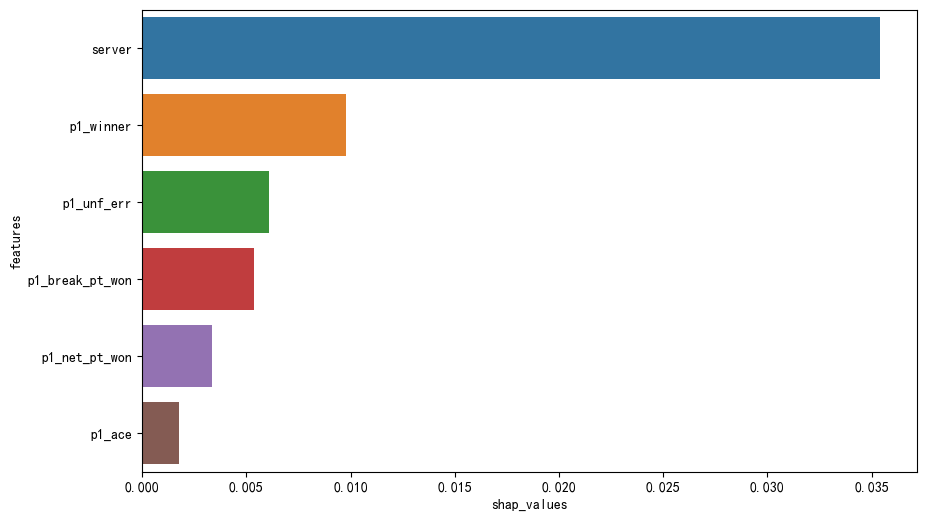

In [32]:
a_sorted = tt.sort_values(by='shap_values', ascending=False)

# 设置图表大小，例如设置为宽10英寸，高6英寸
plt.figure(figsize=(10, 6))
# 使用Seaborn绘制柱状图
sns.barplot(x='shap_values', y='features', data=a_sorted.reset_index(), orient='h')
# plt.savefig('classify')
# 显示图形
plt.show()
#特征重要度